In [56]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('/home/users/cturrell/documents/eddy_feedback/')
import functions.data_wrangling as data 
import functions.eddy_feedback as ef

### MIROC6 Monthly

In [57]:
# import files
miroc_epfy = xr.open_mfdataset('/gws/nopw/j04/arctic_connect/cturrell/PAMIP_data/monthly/pdSST-pdSIC/epfy/MIROC6/*.nc', 
                         combine='nested', concat_dim='ens_ax', parallel=True)
miroc_ua = xr.open_mfdataset('/gws/nopw/j04/arctic_connect/cturrell/PAMIP_data/monthly/pdSST-pdSIC/ua/MIROC6/*.nc', 
                         combine='nested', concat_dim='ens_ax', parallel=True)

# make into dataset
miroc_epfy = miroc_epfy.sel( plev = miroc_ua.plev.values )
miroc_ds = xr.Dataset( {'ubar': miroc_ua.ua.mean('lon'), 'div1': miroc_epfy.epfy})
miroc_ds = miroc_ds.rename({'plev': 'level'})
miroc_ds['level'] = miroc_ds['level'] / 100

# take DJF mean
miroc_ds = data.seasonal_dataset(miroc_ds)
miroc_ds = miroc_ds.mean('time')
miroc_ds = miroc_ds.sel( lat=slice(0,90) )

miroc_ds

<xarray.Dataset>
Dimensions:  (level: 19, lat: 64, ens_ax: 100)
Coordinates:
  * level    (level) float64 1e+03 925.0 850.0 700.0 600.0 ... 20.0 10.0 5.0 1.0
  * lat      (lat) float64 0.7004 2.101 3.502 4.903 ... 84.74 86.14 87.54 88.93
Dimensions without coordinates: ens_ax
Data variables:
    ubar     (ens_ax, level, lat) float32 dask.array<chunksize=(1, 19, 64), meta=np.ndarray>
    div1     (ens_ax, level, lat) float32 dask.array<chunksize=(1, 19, 64), meta=np.ndarray>

In [58]:
print('Calculating NH EFP...')
corr_nh = xr.corr(miroc_ds.div1, miroc_ds.ubar, dim='ens_ax').load()

print(f'MIROC6 ubar has NaN: {np.any(np.isnan(miroc_ds.ubar.values))}')
print(f'MIROC6 div1 has NaN: {np.any(np.isnan(miroc_ds.div1.values))}')

Calculating NH EFP...


/home/users/cturrell/miniforge3/envs/eddy/lib/python3.12/site-packages/dask/array/numpy_compat.py:51: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


MIROC6 ubar has NaN: False
MIROC6 div1 has NaN: True


In [82]:
# find boolean
is_nan = np.isnan(miroc_ds.div1)
is_nan = is_nan.mean('ens_ax')
is_nan

<xarray.DataArray 'div1' (level: 19, lat: 64)>
dask.array<mean_agg-aggregate, shape=(19, 64), dtype=float64, chunksize=(19, 64), chunktype=numpy.ndarray>
Coordinates:
  * level    (level) float64 1e+03 925.0 850.0 700.0 600.0 ... 20.0 10.0 5.0 1.0
  * lat      (lat) float64 0.7004 2.101 3.502 4.903 ... 84.74 86.14 87.54 88.93

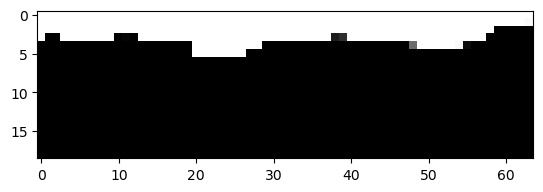

In [83]:
plt.imshow(is_nan.values, cmap='gray')

In [84]:
missing_coords = []

for level in range(len(is_nan['level'])):
    for lat in range(len(is_nan['lat'])):
        # print((level, lat))
        
        # check if entry is True
        if is_nan.values[level, lat]:
            # If true, save coordinates 
            missing_coords.append( (is_nan[level,lat].level.values, is_nan[level,lat].lat.values) )
            
print(f'Number of NaNs: {len(missing_coords)} \nTotal number: {len(is_nan.level)*len(is_nan.lat)}')

missing_coords

Number of NaNs: 265 
Total number: 1216


[(array(1000.), array(0.7003838)),
 (array(1000.), array(2.1011514)),
 (array(1000.), array(3.50191898)),
 (array(1000.), array(4.90268653)),
 (array(1000.), array(6.30345404)),
 (array(1000.), array(7.70422148)),
 (array(1000.), array(9.10498886)),
 (array(1000.), array(10.50575615)),
 (array(1000.), array(11.90652333)),
 (array(1000.), array(13.30729041)),
 (array(1000.), array(14.70805736)),
 (array(1000.), array(16.10882416)),
 (array(1000.), array(17.50959079)),
 (array(1000.), array(18.91035725)),
 (array(1000.), array(20.31112351)),
 (array(1000.), array(21.71188955)),
 (array(1000.), array(23.11265536)),
 (array(1000.), array(24.5134209)),
 (array(1000.), array(25.91418615)),
 (array(1000.), array(27.3149511)),
 (array(1000.), array(28.7157157)),
 (array(1000.), array(30.11647993)),
 (array(1000.), array(31.51724377)),
 (array(1000.), array(32.91800716)),
 (array(1000.), array(34.31877008)),
 (array(1000.), array(35.71953248)),
 (array(1000.), array(37.12029431)),
 (array(1000.

### Subset pressure level

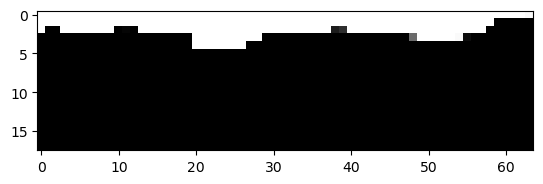

In [85]:
is_nan2 = is_nan.where( is_nan.level < 1000., drop=True)

plt.imshow(is_nan2.values, cmap='gray')

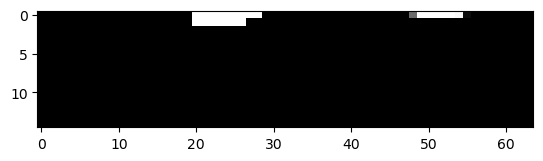

In [87]:
is_nan3 = is_nan.where( is_nan.level < 700., drop=True)

plt.imshow(is_nan3.values, cmap='gray')

In [88]:
missing_coords = []

for level in range(len(is_nan3['level'])):
    for lat in range(len(is_nan3['lat'])):
        # print((level, lat))
        
        # check if entry is True
        if is_nan3.values[level, lat]:
            # If true, save coordinates 
            missing_coords.append( (is_nan3[level,lat].level.values, is_nan3[level,lat].lat.values) )
            
print(f'Number of NaNs: {len(missing_coords)} \nTotal number: {len(is_nan3.level)*len(is_nan3.lat)}')

missing_coords

Number of NaNs: 24 
Total number: 960


[(array(600.), array(28.7157157)),
 (array(600.), array(30.11647993)),
 (array(600.), array(31.51724377)),
 (array(600.), array(32.91800716)),
 (array(600.), array(34.31877008)),
 (array(600.), array(35.71953248)),
 (array(600.), array(37.12029431)),
 (array(600.), array(38.52105553)),
 (array(600.), array(39.92181607)),
 (array(600.), array(67.9366733)),
 (array(600.), array(69.33737157)),
 (array(600.), array(70.73805877)),
 (array(600.), array(72.13873229)),
 (array(600.), array(73.53938863)),
 (array(600.), array(74.94002302)),
 (array(600.), array(76.3406287)),
 (array(600.), array(77.74119587)),
 (array(500.), array(28.7157157)),
 (array(500.), array(30.11647993)),
 (array(500.), array(31.51724377)),
 (array(500.), array(32.91800716)),
 (array(500.), array(34.31877008)),
 (array(500.), array(35.71953248)),
 (array(500.), array(37.12029431))]